# Setup

In [1]:
%load_ext autoreload
%autoreload 3
import sys
sys.path.append('../generalization/')

In [2]:
import torch as th
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from pathlib import Path
from time import time
import itertools
from random import shuffle
from torch.utils.data import DataLoader

# Fix logger bug
import babelnet
from nnsight import logger

logger.disabled = True

_ = th.set_grad_enabled(False)

2024-07-01 20:29:28,500 [babelnet.conf] INFO: Loaded configuration from ['/dlabscratch1/cdumas/babelnet_conf.yml']
2024-07-01 20:29:28,504 [babelnet.api] INFO: BabelNet online RESTful API v1.2.0


In [3]:
exp_name = "lang_patchscope_chris"

## Papermill args

In [4]:
langs = ["fr", "de", "ru", "en", "zh"]
batch_size = 8
model = "Llama-2-7b"
device = "auto"
model_path = "/dlabscratch1/public/llm_weights/llama2_hf/Llama-2-7b-hf"; remote = False
# model_path = "meta-llama/Llama-2-70b-hf"; remote = True
trust_remote_code = False
extra_args = []
exp_id = "chris-test"

## CL Args

## Load and prepare

In [5]:
from exp_tools import load_model

model_name = model.split("/")[-1]
langs = np.array(langs)
if model_path is None:
    model_path = model
nn_model = load_model(
    model_path,
    trust_remote_code=trust_remote_code,
    device_map=device,
    # dispatch=True,
)
tokenizer = nn_model.tokenizer

2024-07-01 20:29:36,796 [datasets] INFO: PyTorch version 2.2.2 available.


## Prompt desing

In [6]:
from prompt_tools import Prompt
from random import sample
from itertools import product


def lang_few_shot_prompts(
    df,
    langs,
    target_lang,
    latent_langs=None,
    lang_per_prompt=None,
    n_per_lang=1,
    num_prompts=200,
    tokenizer=tokenizer,
):
    """
    Generate prompts for few-shot language detection

    Args:
    - df: df generated with get_cloze_dataset
    - langs: list of languages to sample from
    - target_lang: language to detect
    - latent_langs: list of languages to check probability for
    - lang_per_prompt: number of languages per prompt
    - n_per_lang: number of concepts per language

    """
    if lang_per_prompt is None:
        lang_per_prompt = len(langs)
    if latent_langs is None:
        latent_langs = []
    prompts = []
    for _ in range(num_prompts):
        lang_sample = sample(langs, lang_per_prompt)
        concepts = df.sample(n_per_lang * lang_per_prompt)
        prompt = ""
        lang_list = list(zip(*list(product(lang_sample, range(n_per_lang)))))[0]
        shuffle(lang_list)
        for i, lang in enumerate(lang_list):
            row = concepts.iloc[i]
            obj = row[f"senses_{lang}"][0]
            prompt += f"{obj}: {lang}\n"
        prompt += "_:"
        prompts.append(
            Prompt.from_strings(
                prompt, target_lang, {l: l for l in latent_langs}, tokenizer
            )
        )
    return prompts

## Exp constants

In [7]:
id_to_patch = -2
use_obj = True
num_words = 16
# num_words = None  # Use all translation prompts

## Plots

In [8]:
from exp_tools import (
    run_prompts,
)
from interventions import patchscope_lens, TargetPromptBatch
from prompt_tools import lang_few_shot_prompts, translation_prompts
from translation_tools import get_cloze_dataset, get_bn_dataset

from display_utils import plot_topk_tokens, k_subplots, plot_results, plot_k_results
from utils import ulist


def plt_lang_patch(
    input_lang,
    target_lang,
    few_shot_langs,
    extra_langs=None,
    batch_size=batch_size,
    num_words=None,
    exp_id=None,
    num_examples=9,
    use_obj=use_obj,
):
    """
    use_obj: if True, use the source prompts stops at the object to be translated
    """
    if extra_langs is None:
        extra_langs = []
    if isinstance(extra_langs, str):
        extra_langs = [extra_langs]
    global target_prompts, target_probs, latent_probs, source_prompts
    df_tr = get_bn_dataset(input_lang, target_lang, num_words=num_words)
    source_prompts = translation_prompts(
        df_tr, tokenizer, input_lang, target_lang, cut_at_obj=use_obj
    )
    source_prompts = [p.prompt for p in source_prompts]
    df = get_cloze_dataset(
        ulist([input_lang, target_lang, *extra_langs, *few_shot_langs]),
    )
    target_prompts = lang_few_shot_prompts(
        df,
        tokenizer,
        few_shot_langs,
        target_lang,
        [input_lang, *extra_langs],
        num_prompts=len(source_prompts),
    )

    def lang_patchscope(nn_model, prompt_batch, scan):
        src_prompts = source_prompts[
            lang_patchscope.idx : lang_patchscope.idx + len(prompt_batch)
        ]
        lang_patchscope.idx += len(prompt_batch)
        tgt_prompts = TargetPromptBatch.from_prompts(prompt_batch, id_to_patch)
        return patchscope_lens(
            nn_model, src_prompts, tgt_prompts, scan=scan, remote=remote
        )

    lang_patchscope.idx = 0

    target_probs, latent_probs = run_prompts(
        nn_model, target_prompts, batch_size=batch_size, get_probs=lang_patchscope
    )

    json_dic = {
        target_lang: target_probs.tolist(),
    }
    for label, probs in latent_probs.items():
        json_dic[label] = probs.tolist()
    pref = "_".join([])
    path = (
        Path("results")
        / model_name
        / exp_name
        / (f"{pref}-{input_lang}_{target_lang}-")
    )
    path.mkdir(parents=True, exist_ok=True)
    json_file = path / (exp_id + ".json")
    with open(json_file, "w") as f:
        json.dump(json_dic, f, indent=4)

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    pref = pref.replace("_", " ")
    title = f"{model_name}: {exp_name} from ({input_lang} -> {target_lang})"
    plot_results(ax, target_probs, latent_probs, target_lang)
    ax.legend()
    ax.set_title(title)
    plt.tight_layout()
    plot_file = path / (exp_id + ".png")
    plt.savefig(plot_file, dpi=300, bbox_inches="tight")
    plt.show()

    # Plot k examples
    fig, axes = k_subplots(num_examples)
    plot_k_results(axes, target_probs, latent_probs, target_lang, num_examples)
    axes[num_examples - 1].legend()
    fig.suptitle(title)
    plt_file = path / (exp_id + "_k.png")
    fig.savefig(plt_file, dpi=300, bbox_inches="tight")
    fig.show()
    # Compute a single example
    json_meta = {}
    for i in range(num_examples):
        json_meta[i] = {
            "input lang": input_lang,
            "target lang": target_lang,
            "few shot langs": few_shot_langs,
            "extra langs": extra_langs,
            "source prompt": source_prompts[i],
            "target prompt": target_prompts[i].prompt,
            "target prompt target": target_prompts[i].target_strings,
            "target prompt latent": target_prompts[i].latent_strings,
        }
    json_df = pd.DataFrame(json_meta)
    with pd.option_context(
        "display.max_colwidth",
        None,
        "display.max_columns",
        None,
        "display.max_rows",
        None,
    ):
        display(json_df)
    target_prompt_batch = [p.prompt for p in target_prompts[:num_examples]]
    lang_patchscope.idx = 0
    probs = lang_patchscope(
        nn_model,
        target_prompt_batch,
        scan=True,
    )
    file = path / (exp_id + "_heatmap.png")
    plot_topk_tokens(probs, nn_model, title=title, file=file)

    meta_file = path / (exp_id + "_heatmap.meta.json")
    print(f"Saving metadata to {meta_file}")
    with open(meta_file, "w") as f:
        json.dump(json_meta, f, indent=4)

## Selected args for the paper

Running prompts:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


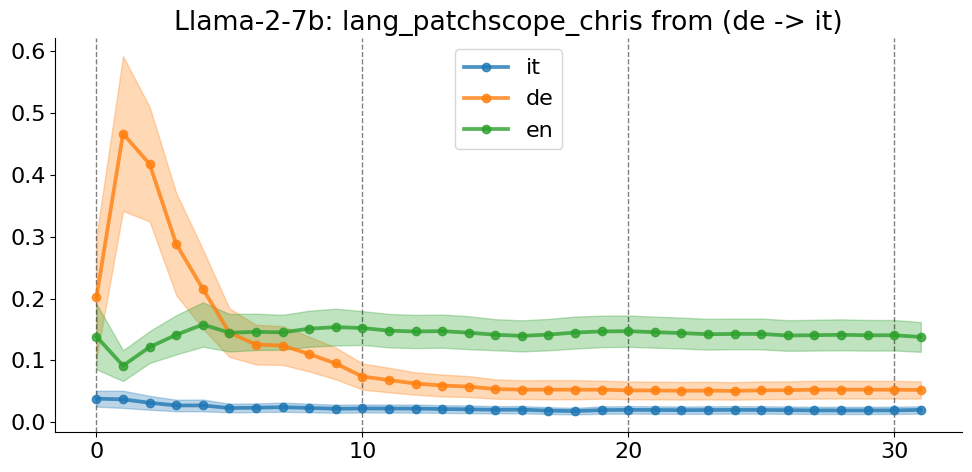

0  \
input lang                                                                                                                                                                                                                                           de   
target lang                                                                                                                                                                                                                                          it   
few shot langs                                                                                                                                                                                                                 [fr, de, ru, en, zh, it]   
extra langs                                                                                                                                                                                                                                        [en]   
source prompt         Deutsch: "Sommer" - Italiano: "stagione estiva"\nDeutsch: "rot" - Italiano: "rosso"\nDeutsch: "Straße" - Italiano: "strada"\nDeutsch: "Osten" - Italiano: "oriente"\nDeutsch: "Plattform" - Italiano: "binario"\nDeutsch: "Schnee   
target prompt                                                                                                                                                         épée: fr\ntown: en\n屋顶: zh\nisola: it\nмеханический тормоз: ru\nGlühbirne: de\n_:   
target prompt target                                                                                                                                                                                                                                 it   
target prompt latent                                                                                                                                                                                                           {'de': 'de', 'en': 'en'}   

                                                                                                                                                                                                                                             1  \
input lang                                                                                                                                                                                                                                  de   
target lang                                                                                                                                                                                                                                 it   
few shot langs                                                                                                                                                                                                        [fr, de, ru, en, zh, it]   
extra langs                                                                                                                                                                                                                               [en]   
source prompt         Deutsch: "Plattform" - Italiano: "binario"\nDeutsch: "Osten" - Italiano: "oriente"\nDeutsch: "Schnee" - Italiano: "nevicata"\nDeutsch: "zehn" - Italiano: "dieci"\nDeutsch: "Lied" - Italiano: "canzone"\nDeutsch: "Turm   
target prompt                                                                                                                                                       cercle: fr\nVerstand: de\nforchetta: it\nbell: en\n拱門: zh\nбейсбол: ru\n_:   
target prompt target                                                                                                                                                                                                                        it   
target prompt latent                              

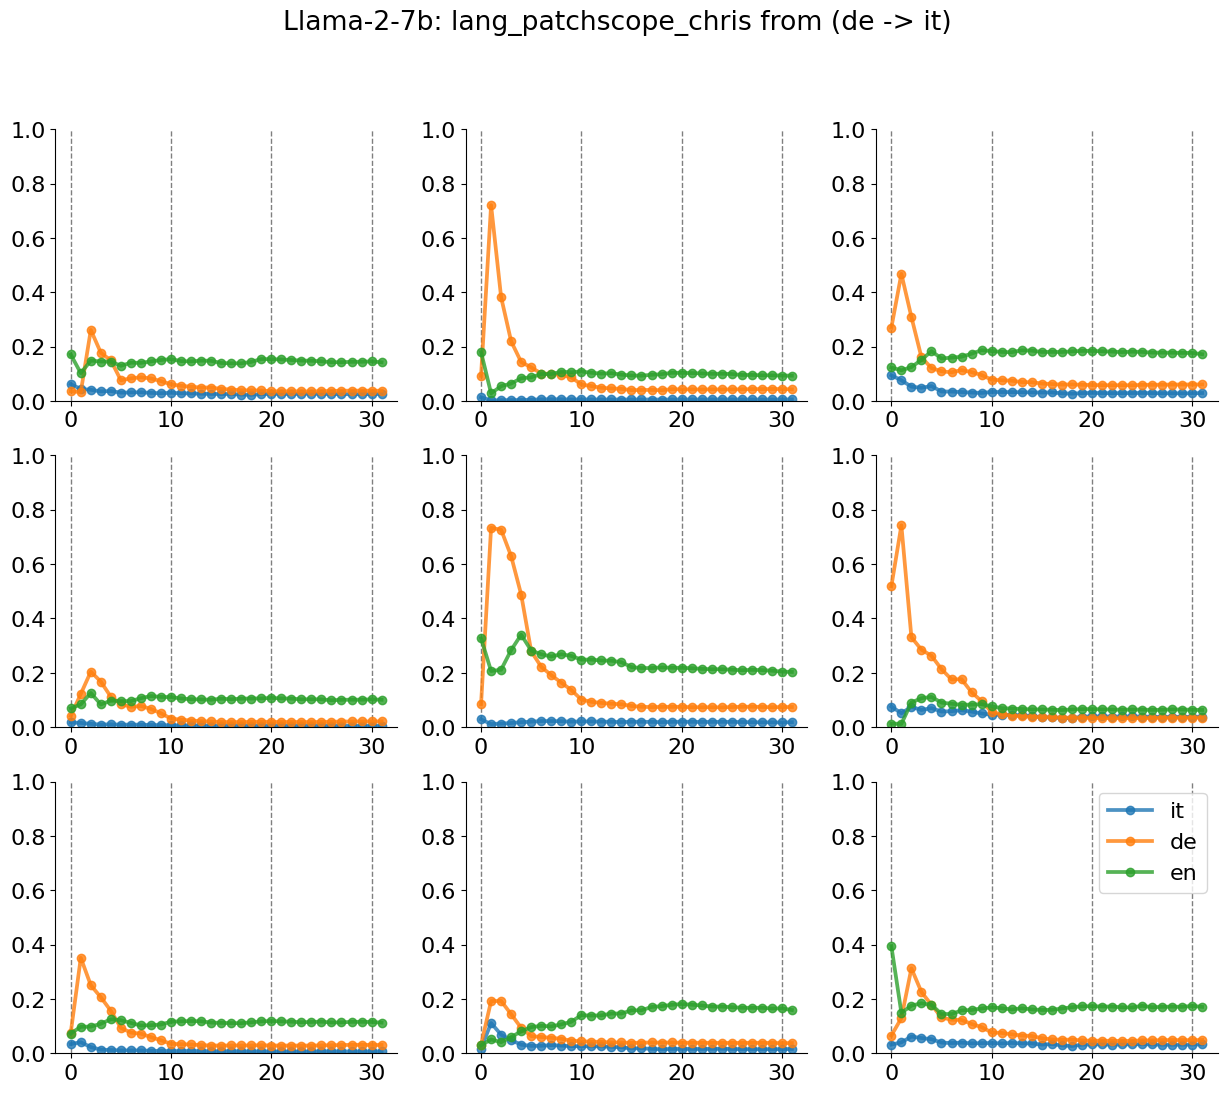

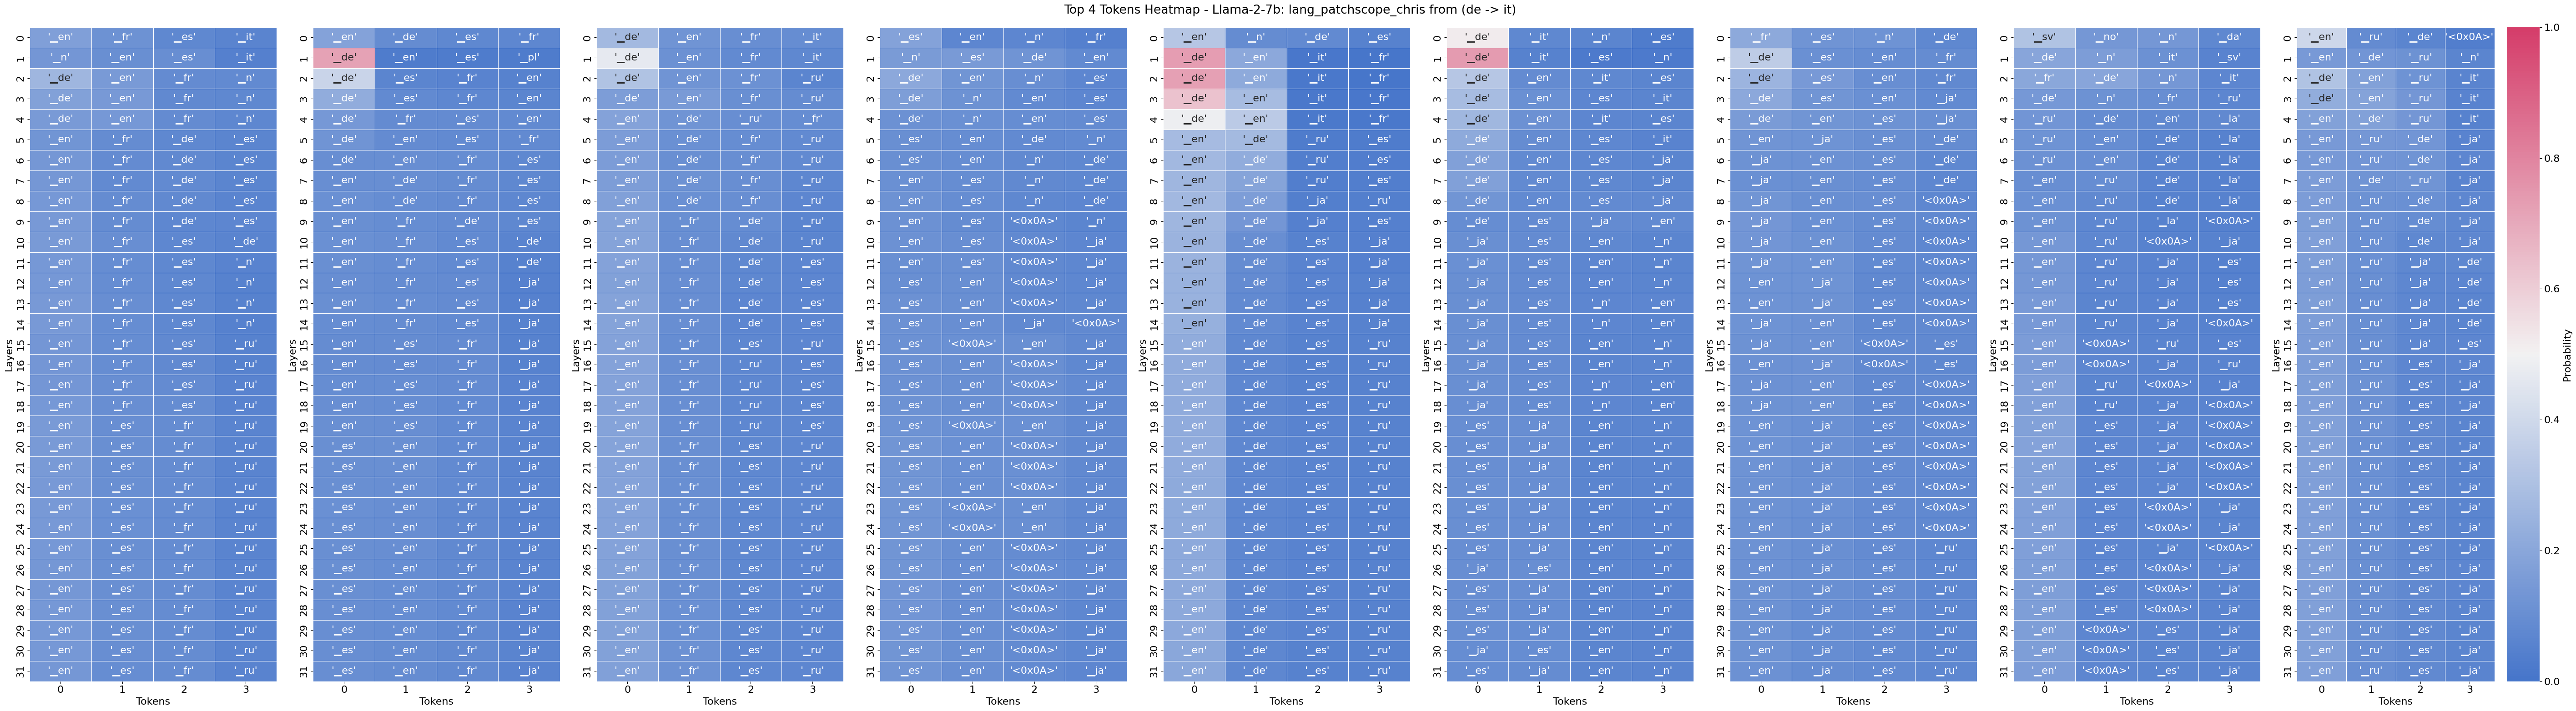

Saving metadata to results/Llama-2-7b/lang_patchscope_chris/-de_it-/chris-test_heatmap.meta.json


Running prompts:   0%|          | 0/2 [00:00<?, ?it/s]

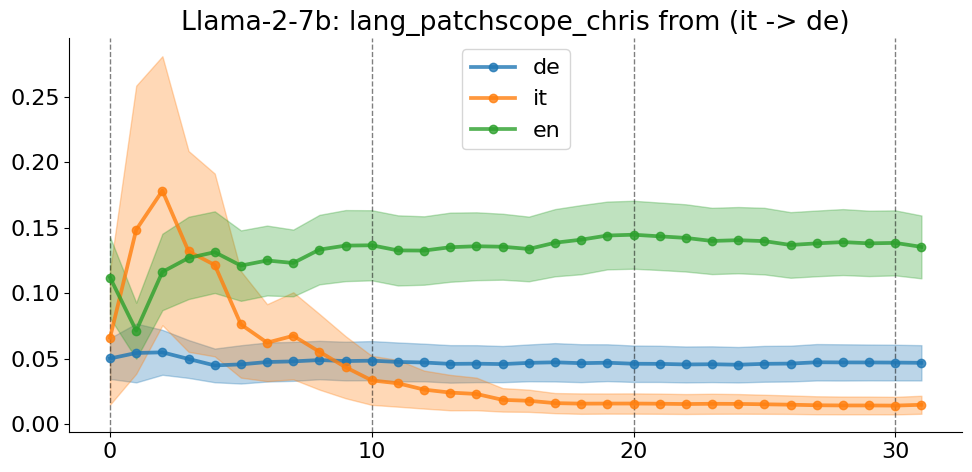

0  \
input lang                                                                                                                                                                                                                                it   
target lang                                                                                                                                                                                                                               de   
few shot langs                                                                                                                                                                                                      [fr, de, ru, en, zh, it]   
extra langs                                                                                                                                                                                                                             [en]   
source prompt         Italiano: "piede" - Deutsch: "Fuß"\nItaliano: "porta" - Deutsch: "Türfutter"\nItaliano: "netto" - Deutsch: "Nettoeinkommen"\nItaliano: "palla" - Deutsch: "Ball"\nItaliano: "mare" - Deutsch: "Meer"\nItaliano: "amico   
target prompt                                                                                                                                                     serpent: fr\nWasserrohr: de\nangolo: it\n鼻子: zh\ndrop: en\nребёнок: ru\n_:   
target prompt target                                                                                                                                                                                                                      de   
target prompt latent                                                                                                                                                                                                {'it': 'it', 'en': 'en'}   

                                                                                                                                                                                                                            1  \
input lang                                                                                                                                                                                                                 it   
target lang                                                                                                                                                                                                                de   
few shot langs                                                                                                                                                                                       [fr, de, ru, en, zh, it]   
extra langs                                                                                                                                                                                                              [en]   
source prompt         Italiano: "piede" - Deutsch: "Fuß"\nItaliano: "palla" - Deutsch: "Ball"\nItaliano: "mare" - Deutsch: "Meer"\nItaliano: "parola" - Deutsch: "Wort"\nItaliano: "Sud" - Deutsch: "Süden"\nItaliano: "Testa   
target prompt                                                                                                                                    Lippe: de\n家禽: zh\nnourrisson: fr\nchest: en\nuniversità: it\nоблако: ru\n_:   
target prompt target                                                                                                                                                                                                       de   
target prompt latent                                                                                                                                                                                 {'it': 'it', 'en': 'en'}   

                                                

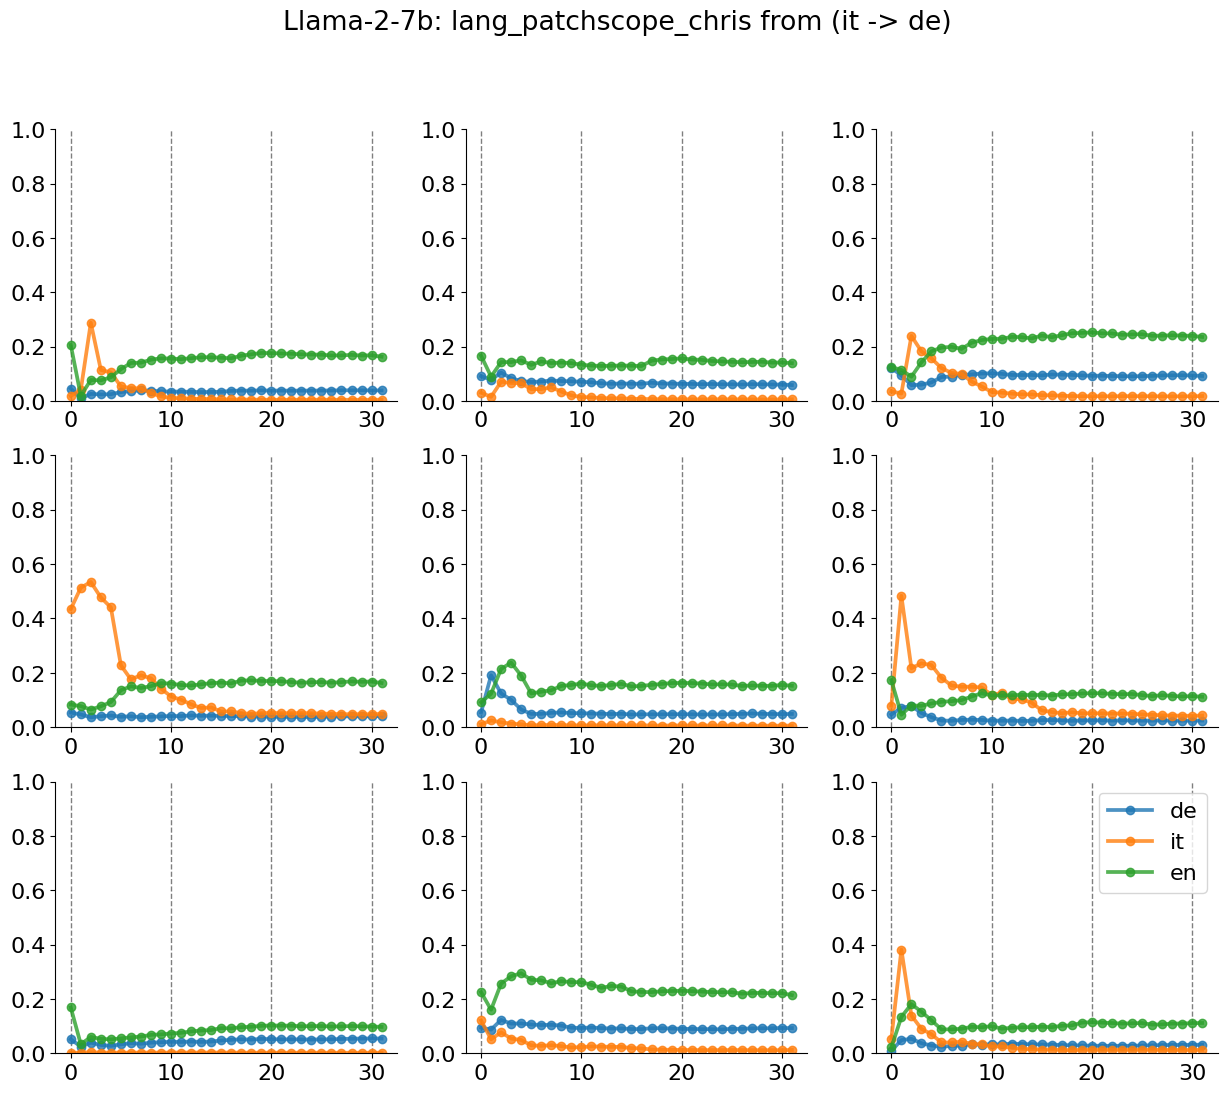

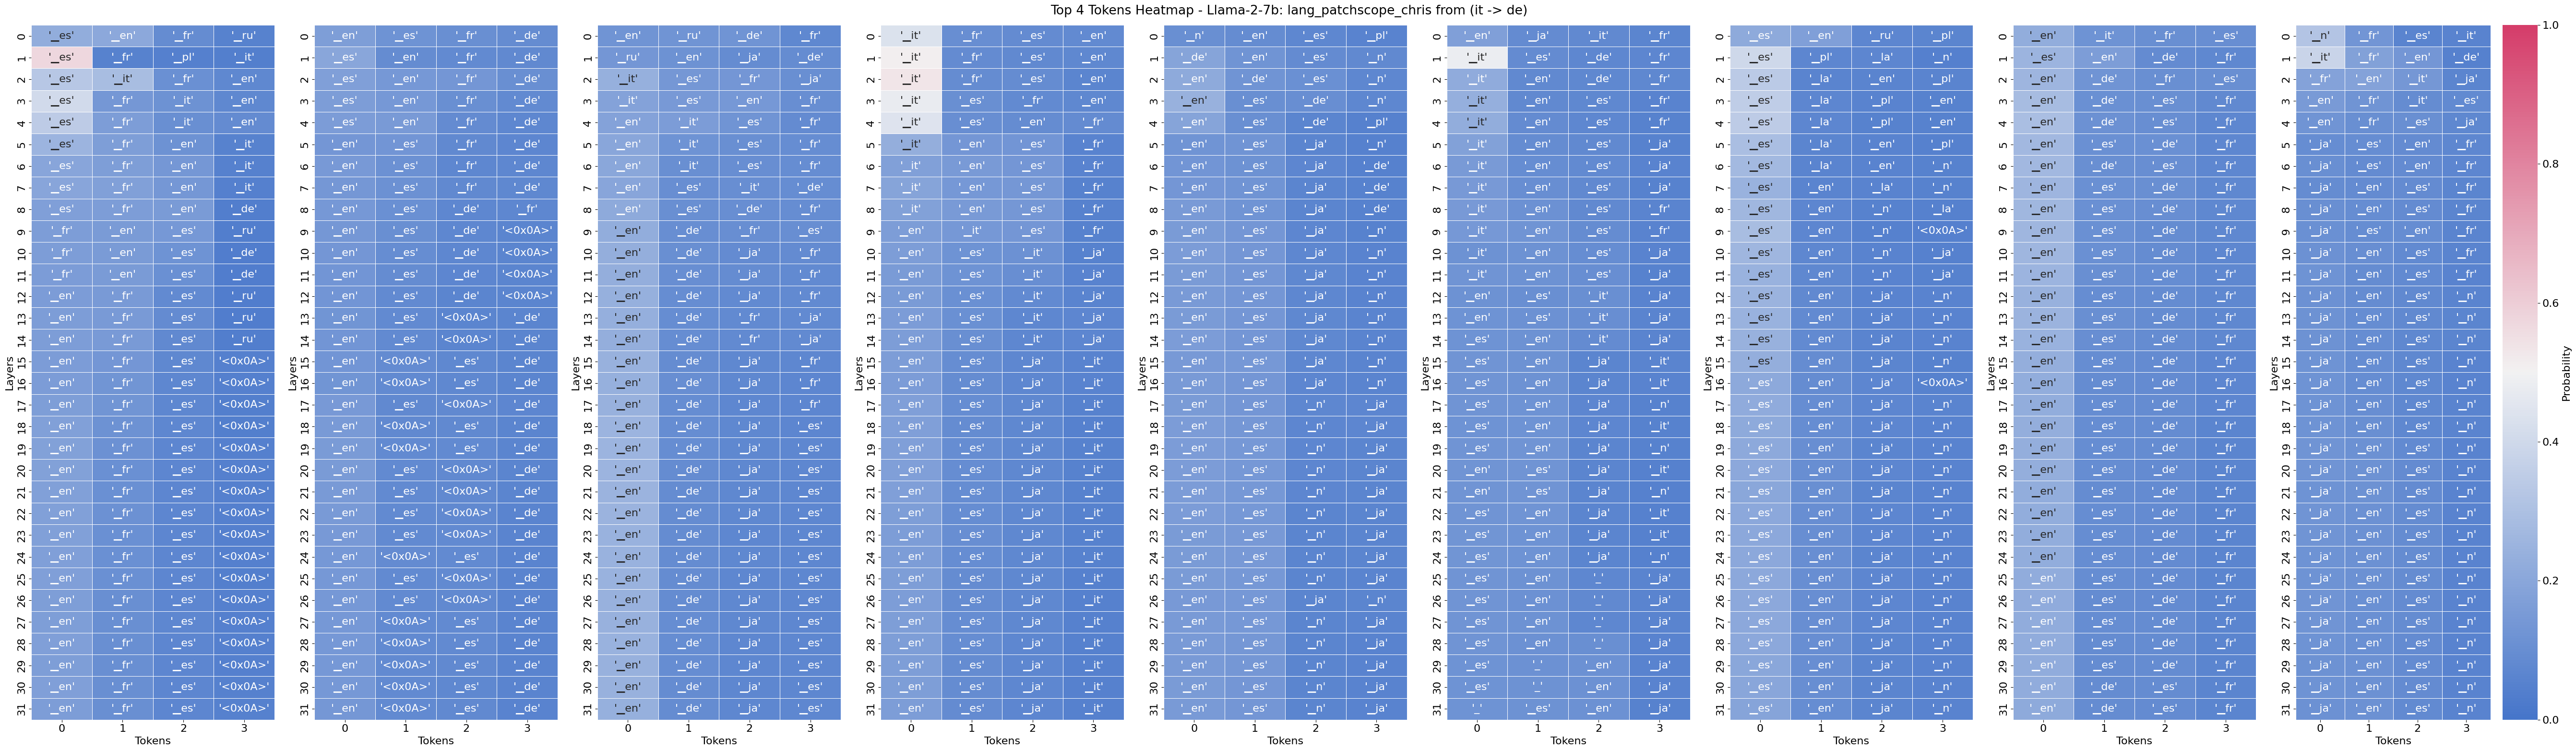

Saving metadata to results/Llama-2-7b/lang_patchscope_chris/-it_de-/chris-test_heatmap.meta.json


Running prompts:   0%|          | 0/2 [00:00<?, ?it/s]

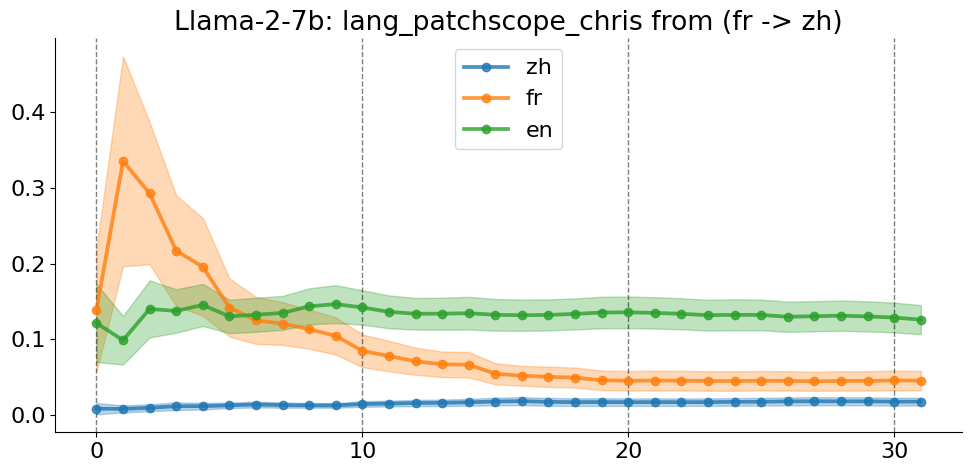

0  \
input lang                                                                                                                                                                             fr   
target lang                                                                                                                                                                            zh   
few shot langs                                                                                                                                                   [fr, de, ru, en, zh, it]   
extra langs                                                                                                                                                                          [en]   
source prompt         Français: "danse" - 中文: "舞蹈"\nFrançais: "source" - 中文: "源泉"\nFrançais: "sol" - 中文: "日头"\nFrançais: "lune" - 中文: "月球"\nFrançais: "paire" - 中文: "雙"\nFrançais: "queue   
target prompt                                                                                                              стол: ru\n拇指: zh\njambe: fr\nlavello: it\nant: en\nTal: de\n_:   
target prompt target                                                                                                                                                                   zh   
target prompt latent                                                                                                                                             {'fr': 'fr', 'en': 'en'}   

                                                                                                                                                                                  1  \
input lang                                                                                                                                                                       fr   
target lang                                                                                                                                                                      zh   
few shot langs                                                                                                                                             [fr, de, ru, en, zh, it]   
extra langs                                                                                                                                                                    [en]   
source prompt         Français: "sol" - 中文: "日头"\nFrançais: "danse" - 中文: "舞蹈"\nFrançais: "lac" - 中文: "湖"\nFrançais: "forêt" - 中文: "林木"\nFrançais: "sud" - 中文: "南"\nFrançais: "lune   
target prompt                                                                                              хвост: ru\nfingernail: en\n煞車: zh\nBauch: de\nfoglia: it\norange: fr\n_:   
target prompt target                                                                                                                                                             zh   
target prompt latent                                                                                                                                       {'fr': 'fr', 'en': 'en'}   

                                                                                                                                                                                        2  \
input lang                                                                                                                                                                             fr   
target lang                                                                                                                                                                            zh   
few shot langs                                                                                                                                                   [fr, de, ru, en, zh, it]   
extra langs                                                                   

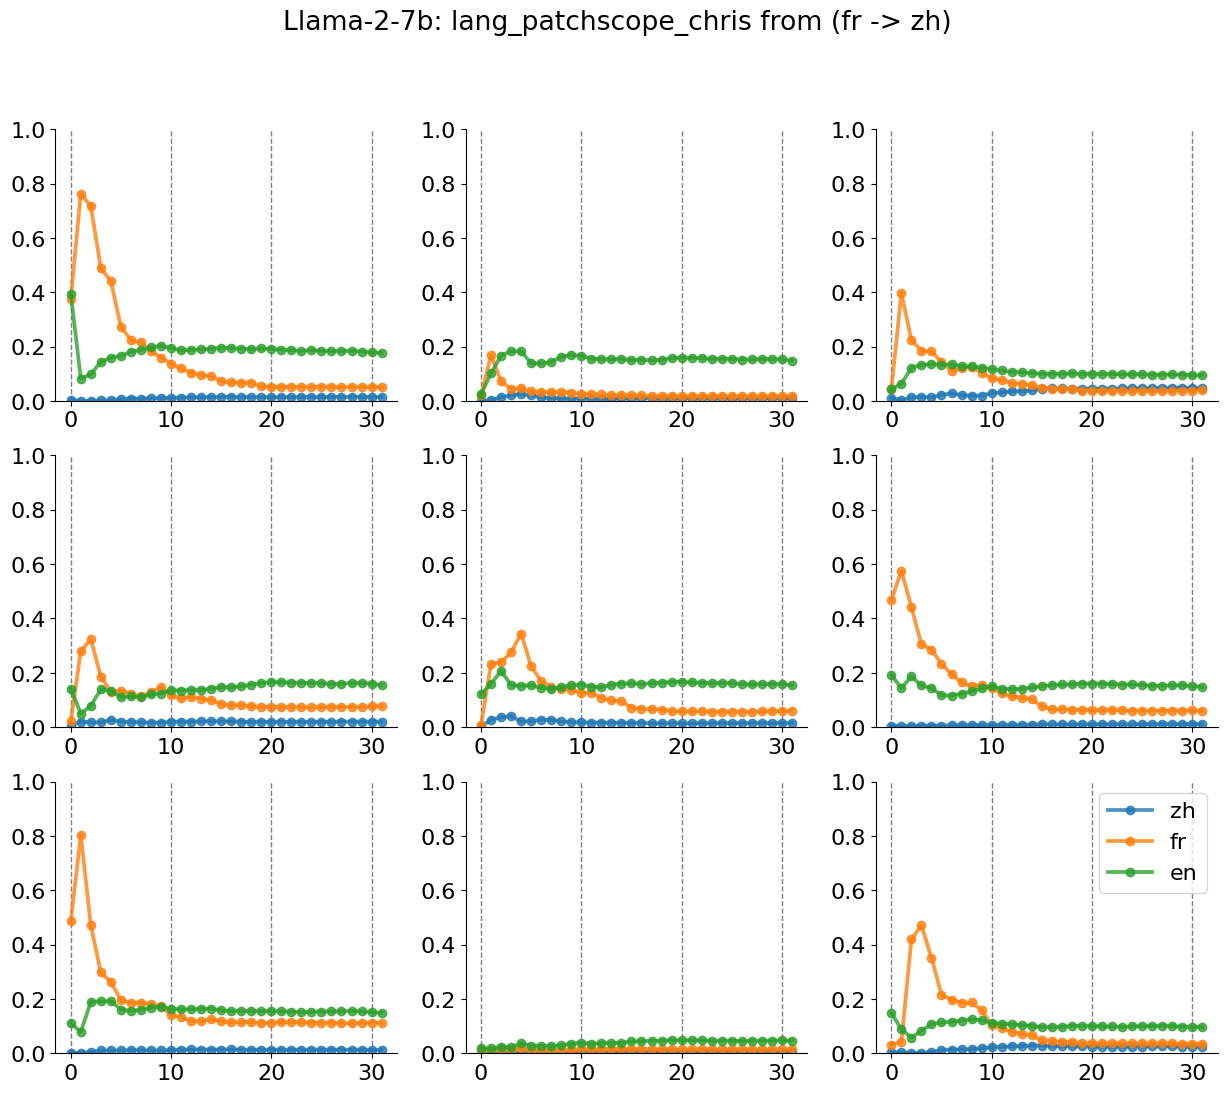

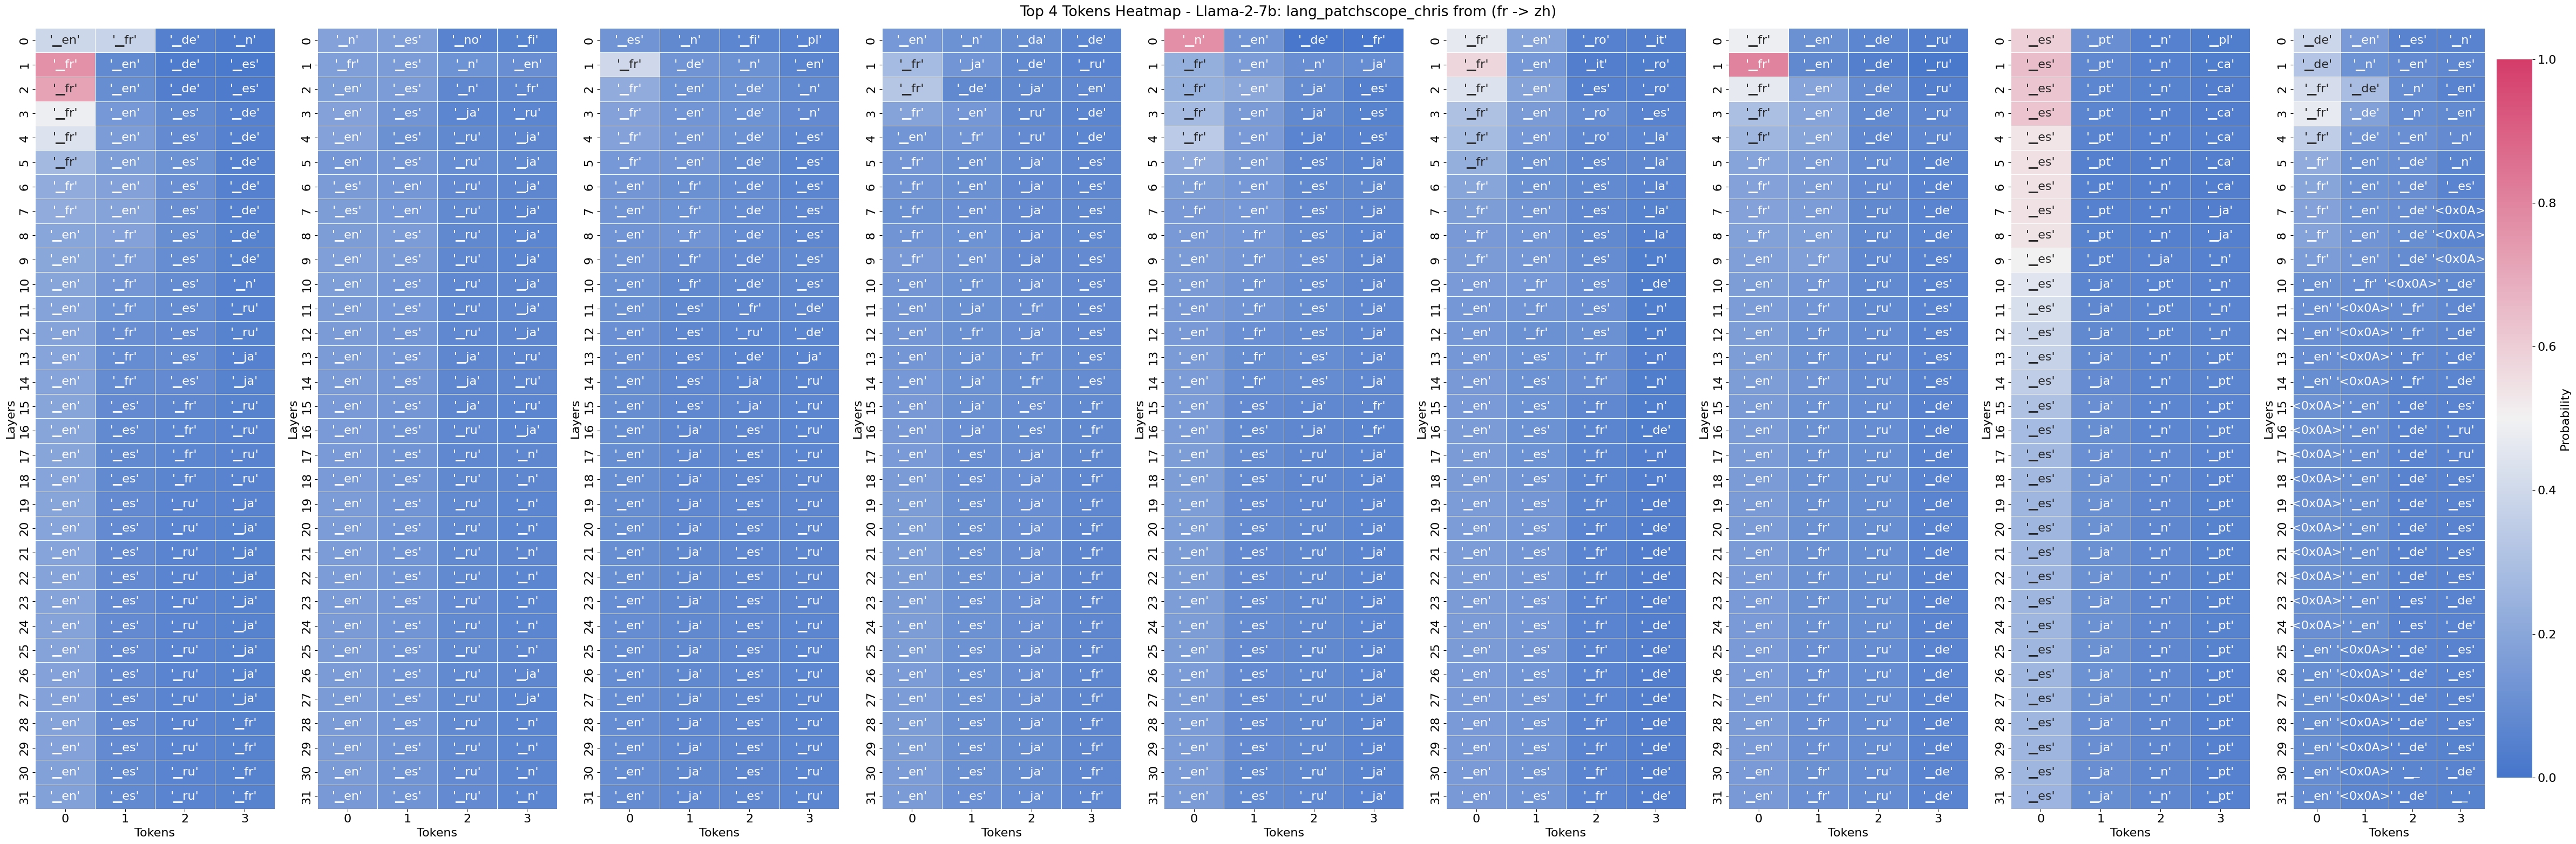

Saving metadata to results/Llama-2-7b/lang_patchscope_chris/-fr_zh-/chris-test_heatmap.meta.json


Running prompts:   0%|          | 0/2 [00:00<?, ?it/s]

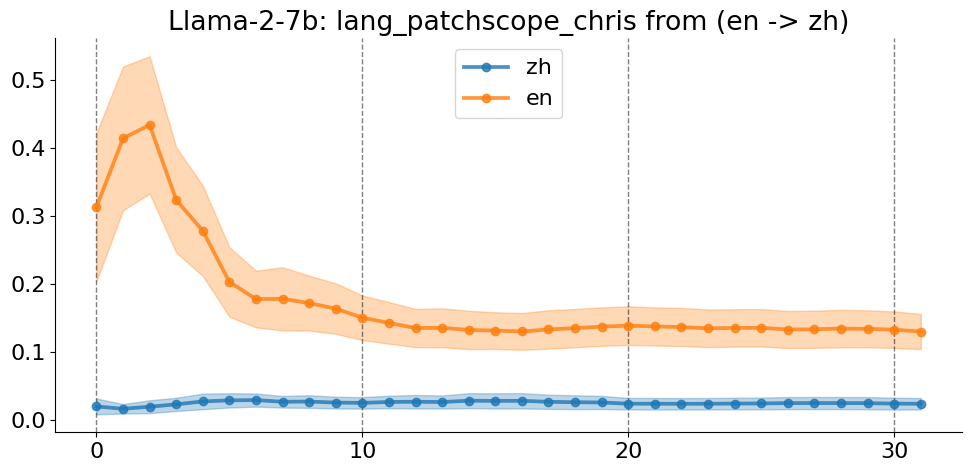

0  \
input lang                                                                                                                                                                        en   
target lang                                                                                                                                                                       zh   
few shot langs                                                                                                                                              [fr, de, ru, en, zh, it]   
extra langs                                                                                                                                                                     [en]   
source prompt         English: "history" - 中文: "歷史"\nEnglish: "meeting" - 中文: "會議"\nEnglish: "hair" - 中文: "发丝"\nEnglish: "five" - 中文: "五"\nEnglish: "rice" - 中文: "稻米"\nEnglish: "ten   
target prompt                                                                                                lèvres: fr\n监狱: zh\nschool: en\nсамоцвет: ru\nHose: de\nformica: it\n_:   
target prompt target                                                                                                                                                              zh   
target prompt latent                                                                                                                                                    {'en': 'en'}   

                                                                                                                                                                                     1  \
input lang                                                                                                                                                                          en   
target lang                                                                                                                                                                         zh   
few shot langs                                                                                                                                                [fr, de, ru, en, zh, it]   
extra langs                                                                                                                                                                       [en]   
source prompt         English: "eight" - 中文: "八"\nEnglish: "spring" - 中文: "源泉"\nEnglish: "hair" - 中文: "发丝"\nEnglish: "fruit" - 中文: "水果"\nEnglish: "river" - 中文: "河"\nEnglish: "meeting   
target prompt                                                                                       passenger train: en\nSchusswaffe: de\nala: it\n葉子: zh\nчервяк: ru\nsifflet: fr\n_:   
target prompt target                                                                                                                                                                zh   
target prompt latent                                                                                                                                                      {'en': 'en'}   

                                                                                                                                                                              2  \
input lang                                                                                                                                                                   en   
target lang                                                                                                                                                                  zh   
few shot langs                                                                                                                                         [fr, de, ru, en, zh, it]   
extra langs                                                                                                                        

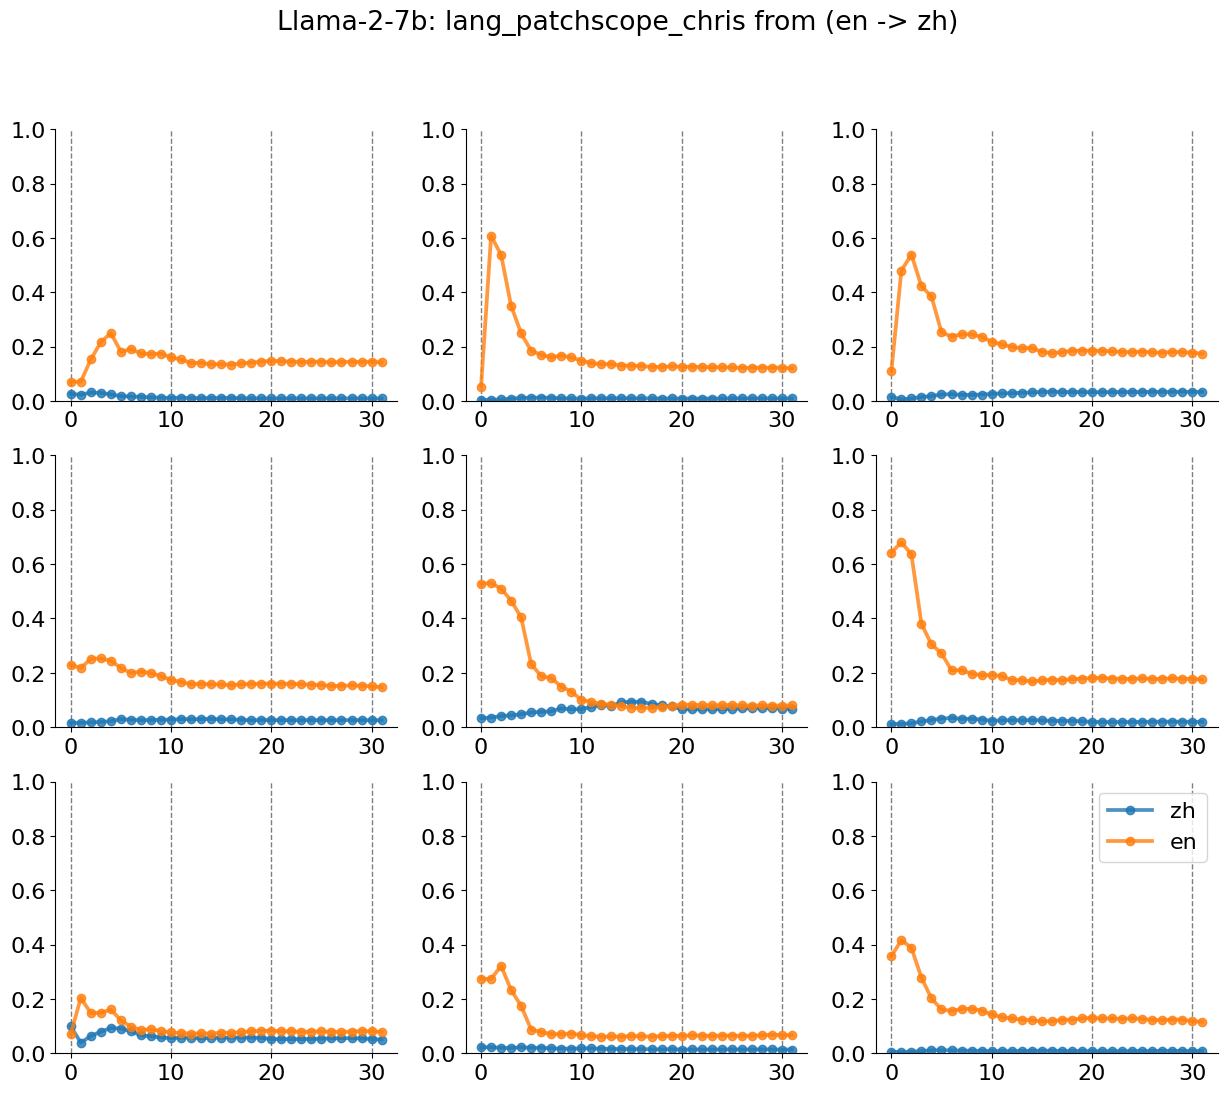

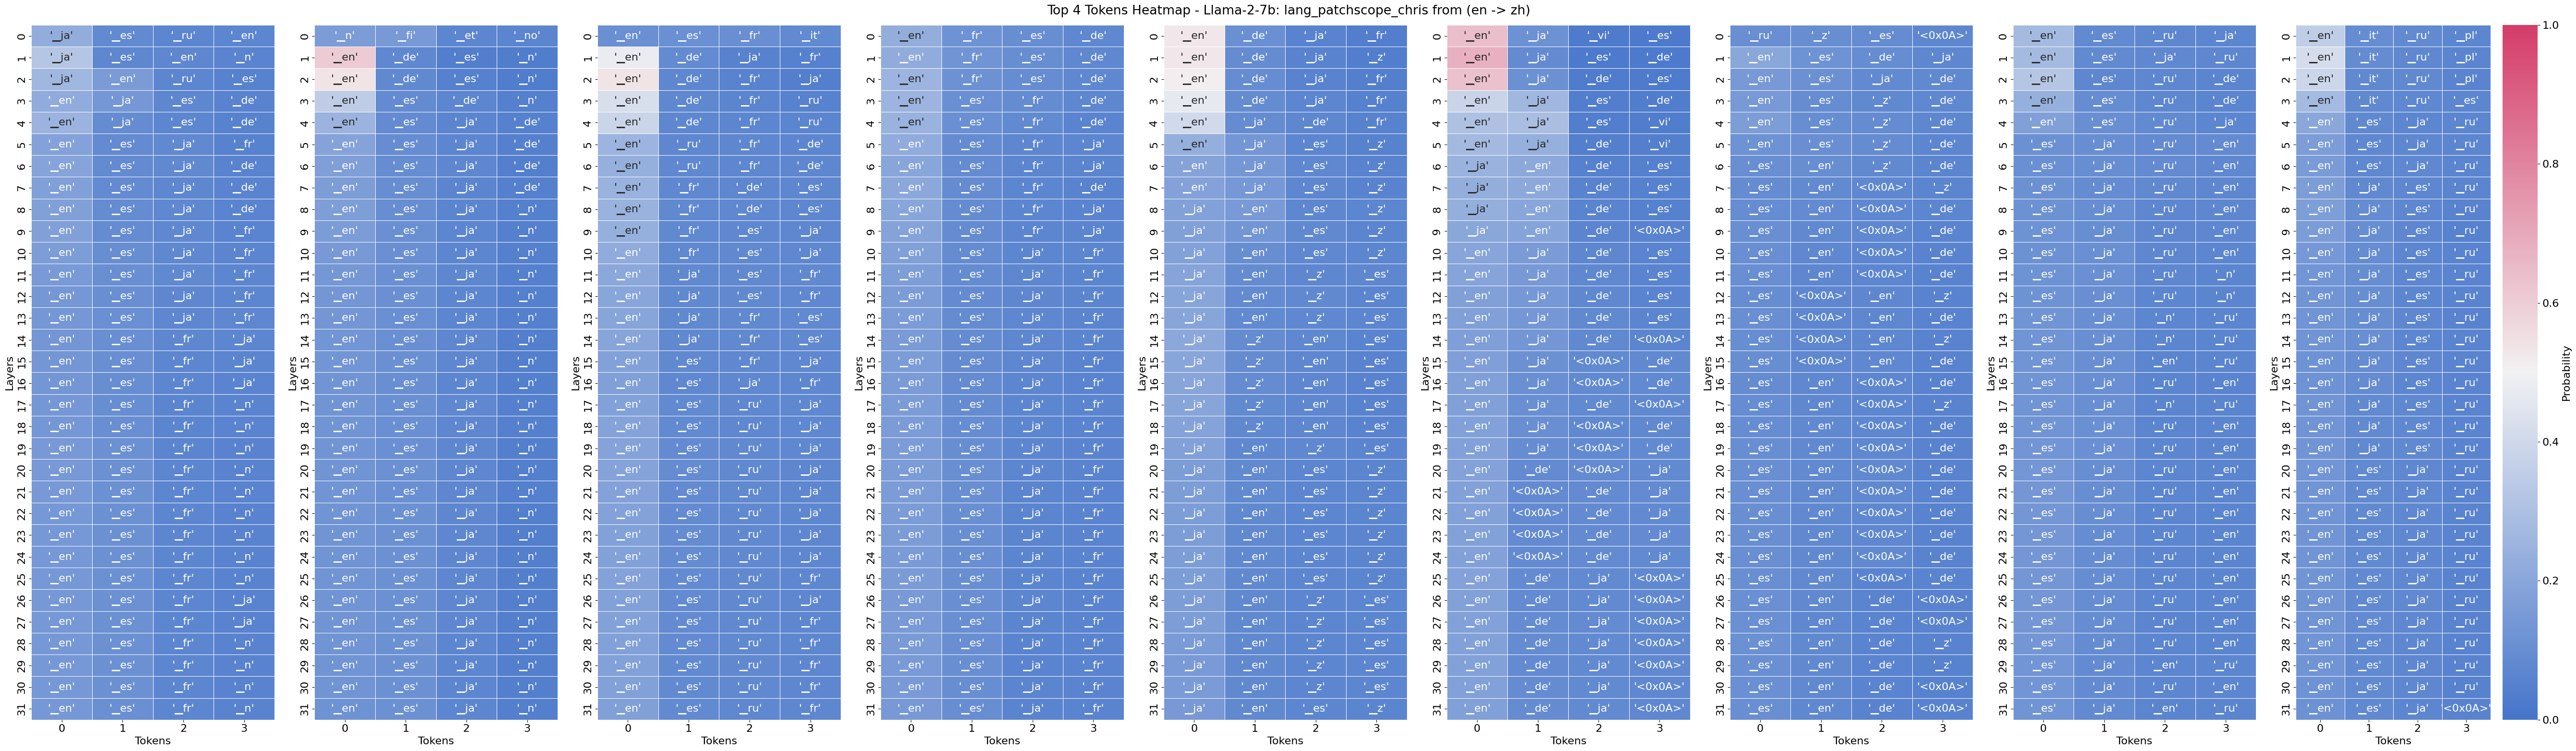

Saving metadata to results/Llama-2-7b/lang_patchscope_chris/-en_zh-/chris-test_heatmap.meta.json


Running prompts:   0%|          | 0/2 [00:00<?, ?it/s]

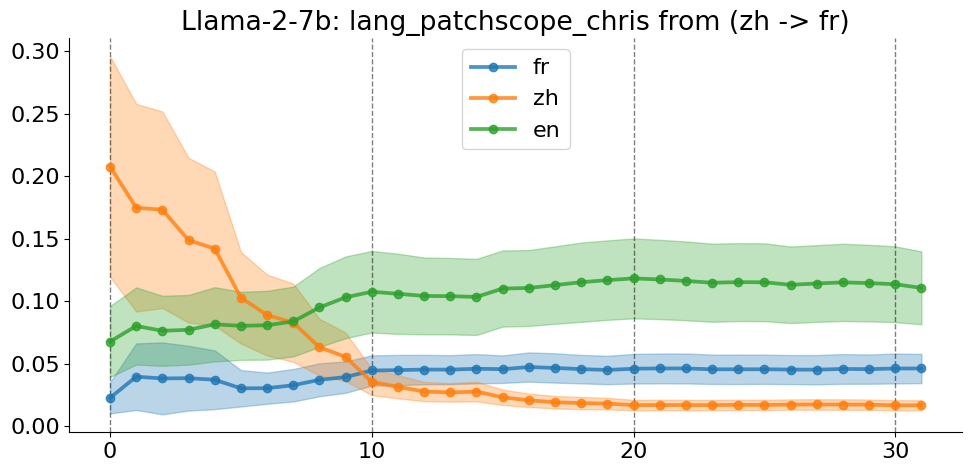

0  \
input lang                                                                                                                                                                      zh   
target lang                                                                                                                                                                     fr   
few shot langs                                                                                                                                            [fr, de, ru, en, zh, it]   
extra langs                                                                                                                                                                   [en]   
source prompt         中文: "雪" - Français: "neige"\n中文: "屋" - Français: "domicile"\n中文: "线" - Français: "route"\n中文: "六" - Français: "six"\n中文: "白" - Français: "blancheur"\n中文: "双   
target prompt                                                                                             莓果: zh\nцерковь: ru\ncomb: en\nacadémie: fr\ncappello: it\nPflug: de\n_:   
target prompt target                                                                                                                                                            fr   
target prompt latent                                                                                                                                      {'zh': 'zh', 'en': 'en'}   

                                                                                                                                                                           1  \
input lang                                                                                                                                                                zh   
target lang                                                                                                                                                               fr   
few shot langs                                                                                                                                      [fr, de, ru, en, zh, it]   
extra langs                                                                                                                                                             [en]   
source prompt         中文: "法" - Français: "loi"\n中文: "木" - Français: "aubier"\n中文: "双" - Français: "paire"\n中文: "水" - Français: "eau"\n中文: "布" - Français: "textile"\n中文: "白   
target prompt                                                                                     无篷小船: zh\njardin: fr\nкожа: ru\nclothes: en\nneonato: it\nSchlange: de\n_:   
target prompt target                                                                                                                                                      fr   
target prompt latent                                                                                                                                {'zh': 'zh', 'en': 'en'}   

                                                                                                                                                                             2  \
input lang                                                                                                                                                                  zh   
target lang                                                                                                                                                                 fr   
few shot langs                                                                                                                                        [fr, de, ru, en, zh, it]   
extra langs                                                                                                                                                               [en]   
source prompt         中文: "河" - Français: "rivière"\n中文: "布" - 

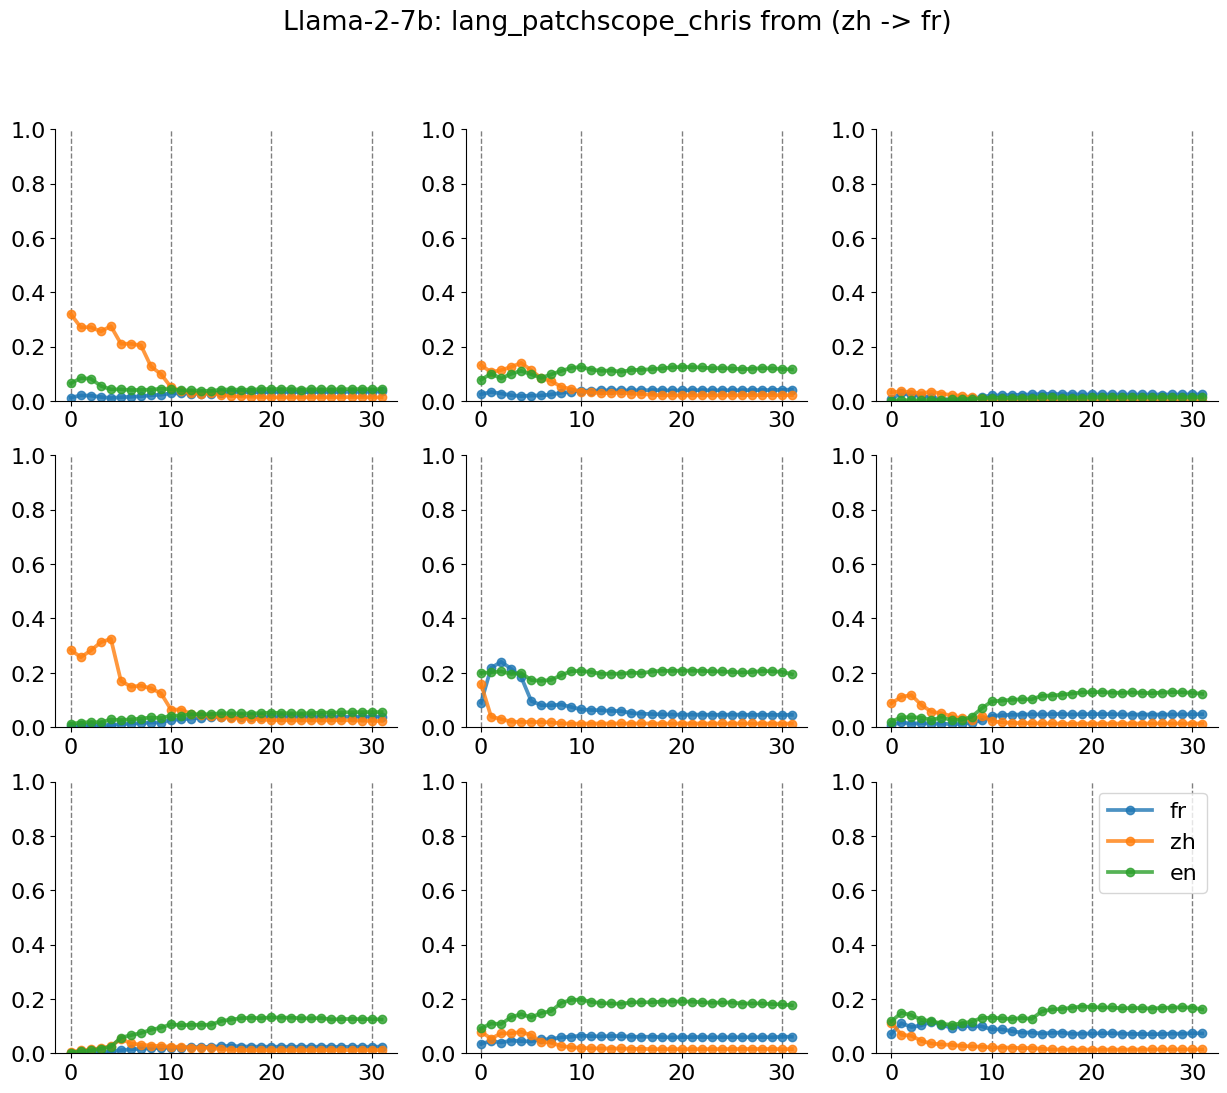

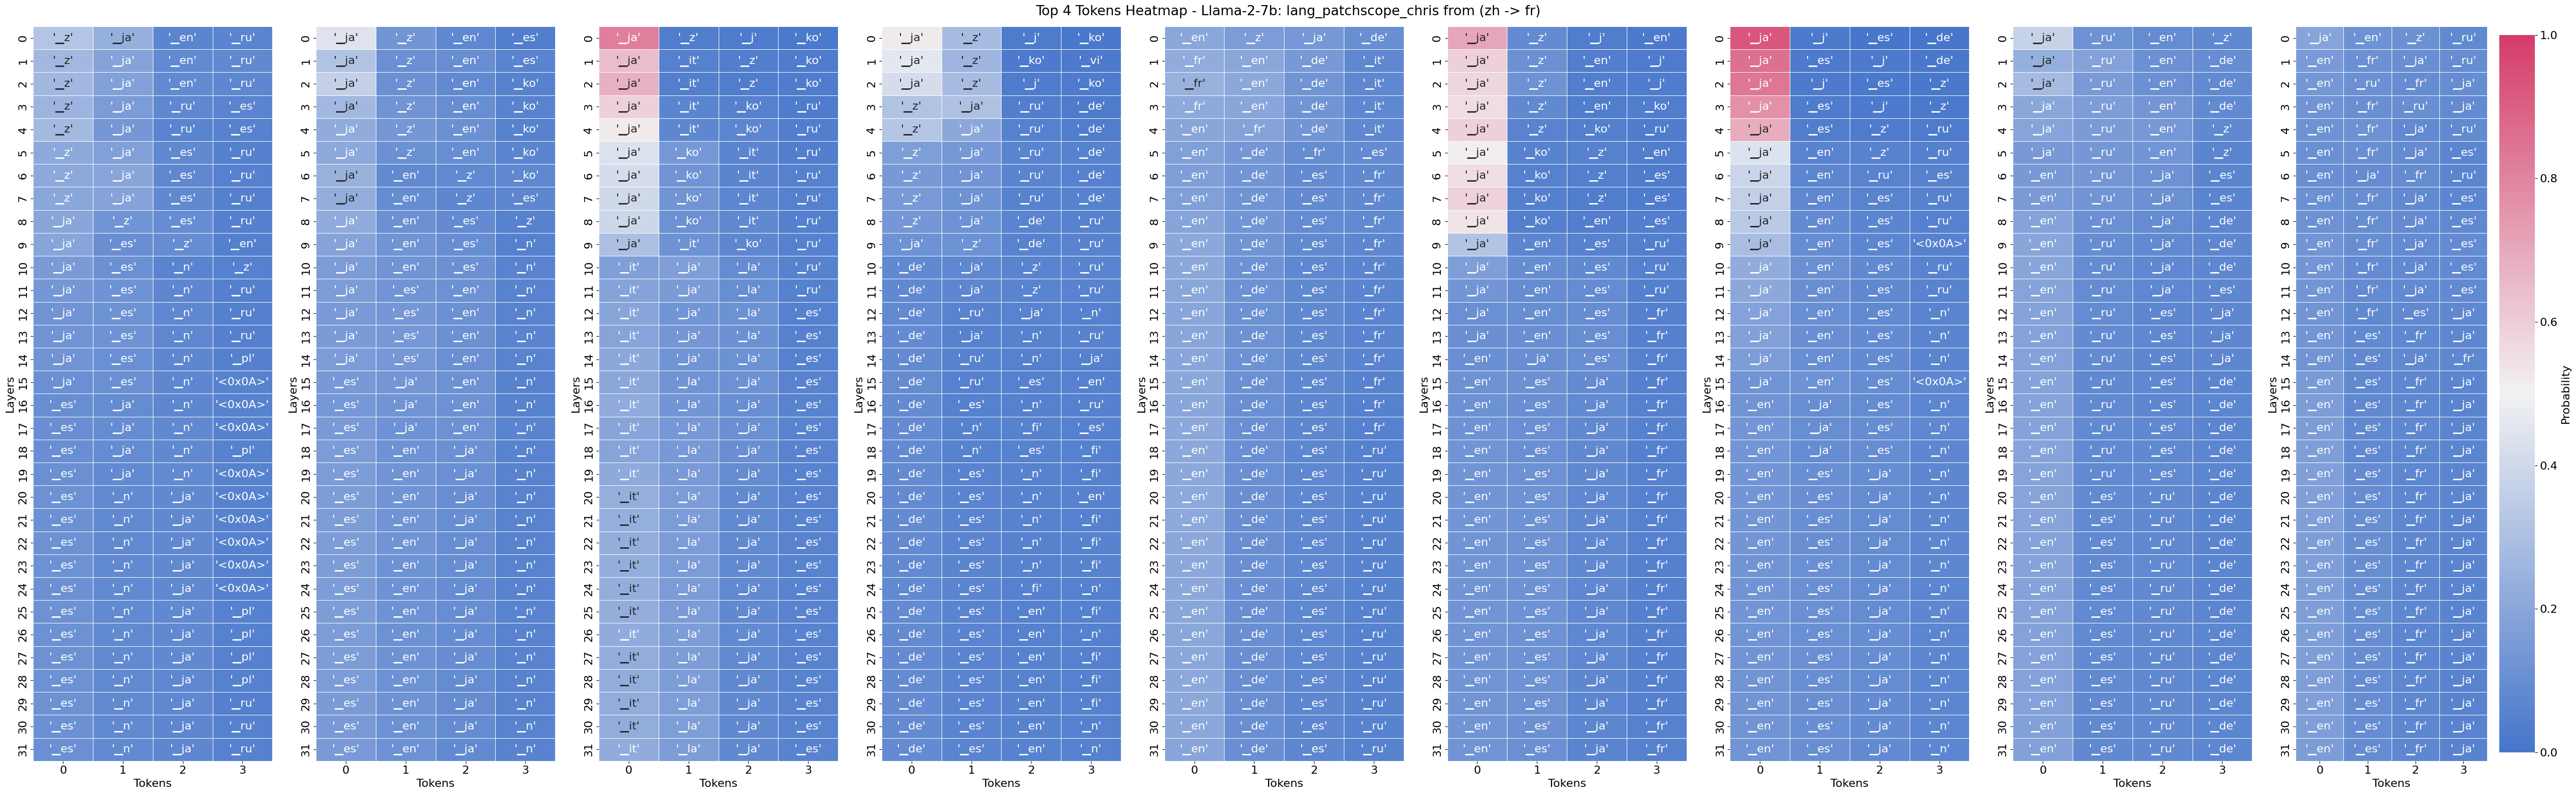

Saving metadata to results/Llama-2-7b/lang_patchscope_chris/-zh_fr-/chris-test_heatmap.meta.json


Running prompts:   0%|          | 0/2 [00:00<?, ?it/s]

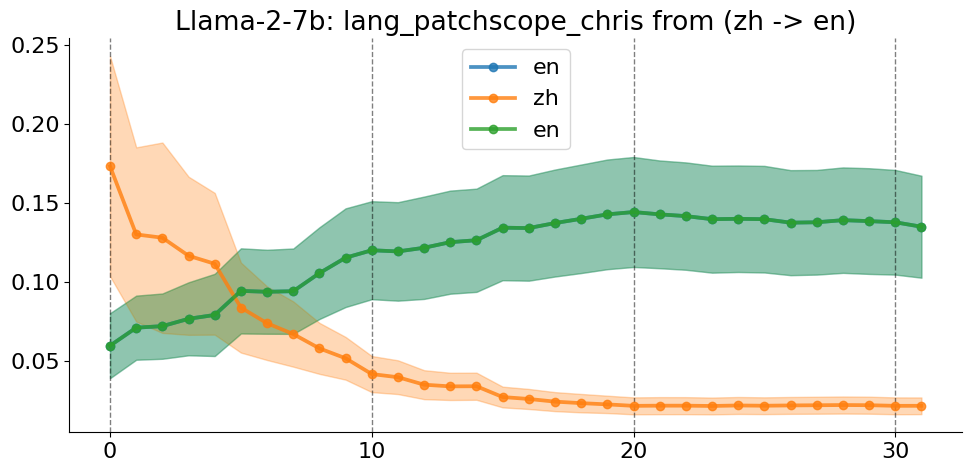

0  \
input lang                                                                                                                                                           zh   
target lang                                                                                                                                                          en   
few shot langs                                                                                                                                 [fr, de, ru, en, zh, it]   
extra langs                                                                                                                                                        [en]   
source prompt         中文: "村" - English: "village"\n中文: "茶" - English: "tea"\n中文: "母" - English: "mother"\n中文: "星" - English: "star"\n中文: "人" - English: "homo"\n中文: "足   
target prompt                                                                                     Herz: de\ncarretto: it\n教會: zh\nкпюч: ru\npencil: en\nplateau: fr\n_:   
target prompt target                                                                                                                                                 en   
target prompt latent                                                                                                                           {'zh': 'zh', 'en': 'en'}   

                                                                                                                                                                         1  \
input lang                                                                                                                                                              zh   
target lang                                                                                                                                                             en   
few shot langs                                                                                                                                    [fr, de, ru, en, zh, it]   
extra langs                                                                                                                                                           [en]   
source prompt         中文: "村" - English: "village"\n中文: "金" - English: "gold"\n中文: "海" - English: "sea"\n中文: "时" - English: "tense"\n中文: "部" - English: "ministry"\n中文: "星   
target prompt                                                                              大學: zh\nlibro: it\nbottine: fr\nсамоцвет: ru\nWand: de\npassenger train: en\n_:   
target prompt target                                                                                                                                                    en   
target prompt latent                                                                                                                              {'zh': 'zh', 'en': 'en'}   

                                                                                                                                                                         2  \
input lang                                                                                                                                                              zh   
target lang                                                                                                                                                             en   
few shot langs                                                                                                                                    [fr, de, ru, en, zh, it]   
extra langs                                                                                                                                                           [en]   
source prompt         中文: "夏" - English: "summertime"\n中文: "母" - English: "mother"\n中文: "人" - English: "homo"\n中文: "星" - English: "star"\n中文: "洋" - English: "sea"\n中文: "门   
target prompt  

In [9]:
paper_args = [
    ("de", "it"),
    ("it", "de"),
    ("fr", "zh"),
    ("en", "zh"),
    ("zh", "fr"),
    ("zh", "en"),
]
fs_langs = ["fr", "de", "ru", "en", "zh", "it"]
for f_args in paper_args:
    th.cuda.empty_cache()
    plt_lang_patch(*f_args, fs_langs, extra_langs="en", exp_id=exp_id, use_obj=use_obj, num_words=num_words)